In [1]:
# Import Libraries

import h5py  # Importing the h5py library for saving the model
import os  # Importing the OS library for reading the dataset
import cv2  # Importing the OpenCV library for image processing
import seaborn as sns  # Importing seaborn for data visualization
import random  # Importing the random library for randomizing the dataset
import pickle  # Importing the Pickle library for serializing and de-serializing the Python object structure
import numpy as np  # Importing the Numpy library for scientific computing
import pandas as pd  # Importing the Pandas library for data analysis
import matplotlib.pyplot as plt  # Importing the Matplotlib library for data visualization
import tensorflow as tf  # Importing the Tensorflow library for deep learning

from PIL import Image  # Importing the Image function from PIL
from tensorflow import keras  # Importing the Keras library for deep learning
from sklearn.model_selection import (
    train_test_split,
)  # Importing the train_test_split function from sklearn.model_selection
from keras.preprocessing.image import (
    ImageDataGenerator,
)  # Importing the ImageDataGenerator function from tensorflow.keras.preprocessing.image
from keras.optimizers import (
    Adam,
)  # Importing the Adam function from tensorflow.keras.optimizers
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
)  # Importing the classification_report, confusion_matrix, accuracy_score function from sklearn.metrics
from matplotlib.image import (
    imread,
)  # Importing the imread function from matplotlib.image
from matplotlib import style  # Importing the style function from matplotlib

sns.set()  # Setting the default seaborn style for our plots
np.random.seed(42)  # Setting the seed value to 42 for reproducibility
style.use("fivethirtyeight")  # Setting the style of the plots

# Setting GPU device to run tensorflow
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
data_dir = "./database/"  # Setting the path of the dataset
train_path = "./database/Train"  # Setting the path of the training dataset
test_path = "./database/"  # Setting the path of the testing dataset

# Resizing the images to 30x30 pixels
IMG_HEIGHT = 30
IMG_WIDTH = 30
NUM_CATEGORIES = len(os.listdir(train_path))  # Number of categories of traffic signs

channels = 3  # Setting the number of channels of the images

print(
    "Number of Categories:", NUM_CATEGORIES
)  # Printing the number of categories of traffic signs

# Label Encoding the traffic signs
classes = {}

# Defining the function to load the Traffic Sign Classes from the CSV file
data = pd.read_csv("trafficSignClasses.csv")
for i in range(len(data)):
    classes[data["ClassId"][i]] = data["ClassName"][i]

print(classes)

Number of Categories: 43
{0: 'Speed limit (20km/h)', 1: 'Speed limit (30km/h)', 2: 'Speed limit (50km/h)', 3: 'Speed limit (60km/h)', 4: 'Speed limit (70km/h)', 5: 'Speed limit (80km/h)', 6: 'End of speed limit (80km/h)', 7: 'Speed limit (100km/h)', 8: 'Speed limit (120km/h)', 9: 'No passing', 10: 'No passing veh over 3.5 tons', 11: 'Right-of-way at intersection', 12: 'Priority road', 13: 'Yield', 14: 'Stop', 15: 'No vehicles', 16: 'Veh > 3.5 tons prohibited', 17: 'No entry', 18: 'General caution', 19: 'Dangerous curve left', 20: 'Dangerous curve right', 21: 'Double curve', 22: 'Bumpy road', 23: 'Slippery road', 24: 'Road narrows on the right', 25: 'Road work', 26: 'Traffic signals', 27: 'Pedestrians', 28: 'Children crossing', 29: 'Bicycles crossing', 30: 'Beware of ice/snow', 31: 'Wild animals crossing', 32: 'End speed + passing limits', 33: 'Turn right ahead', 34: 'Turn left ahead', 35: 'Ahead only', 36: 'Go straight or right', 37: 'Go straight or left', 38: 'Keep right', 39: 'Keep l

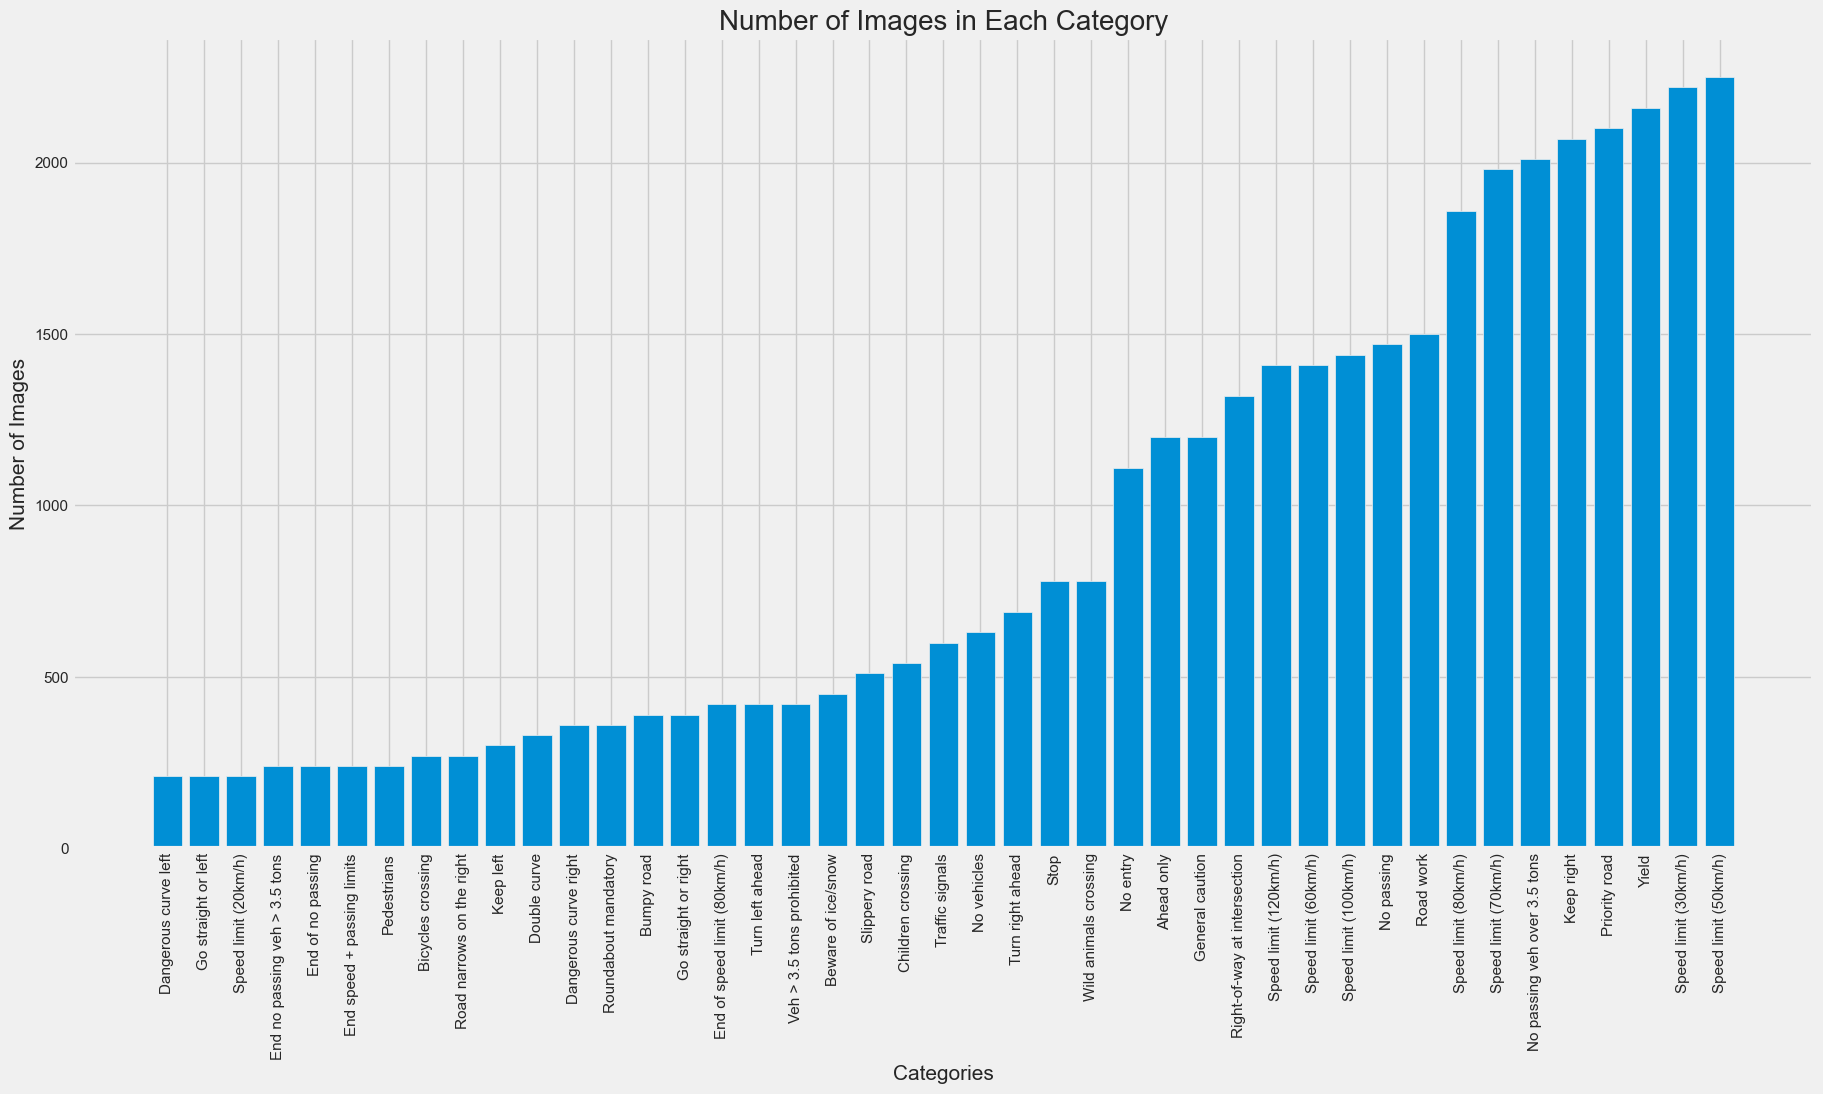

In [3]:
folders = os.listdir(train_path)  # Listing the folders in the training dataset

train_number = []  # Initializing the list for the number of images in each category
class_number = []  # Initializing the list for the number of categories

# Looping through the folders in the training dataset
for folder in folders:
    train_files = os.listdir(
        os.path.join(train_path, folder)
    )  # Listing the files in the folder
    train_number.append(
        len(train_files)
    )  # Appending the number of images in the folder to the list
    class_number.append(
        classes[int(folder)]
    )  # Appending the number of categories to the list

# Creating a dataframe for the number of images in each category
zipped_lists = zip(train_number, class_number)  # Zipping the lists
sorted_pairs = sorted(zipped_lists)  # Sorting the zipped lists
tuples = zip(*sorted_pairs)  # Unzipping the sorted lists
train_number, class_number = [
    list(tuple) for tuple in tuples
]  # Converting the unzipped lists to lists

# Plotting the number of images in each category
plt.figure(figsize=(20, 10))  # Setting the figure size
plt.bar(class_number, train_number)  # Plotting the bar chart
plt.title(
    "Number of Images in Each Category", fontsize=20
)  # Setting the title of the plot
plt.xlabel("Categories", fontsize=15)  # Setting the label for the x-axis
plt.ylabel("Number of Images", fontsize=15)  # Setting the label for the y-axis
plt.xticks(class_number, rotation="vertical")  # Setting the ticks for the x-axis
plt.show()  # Displaying the plot

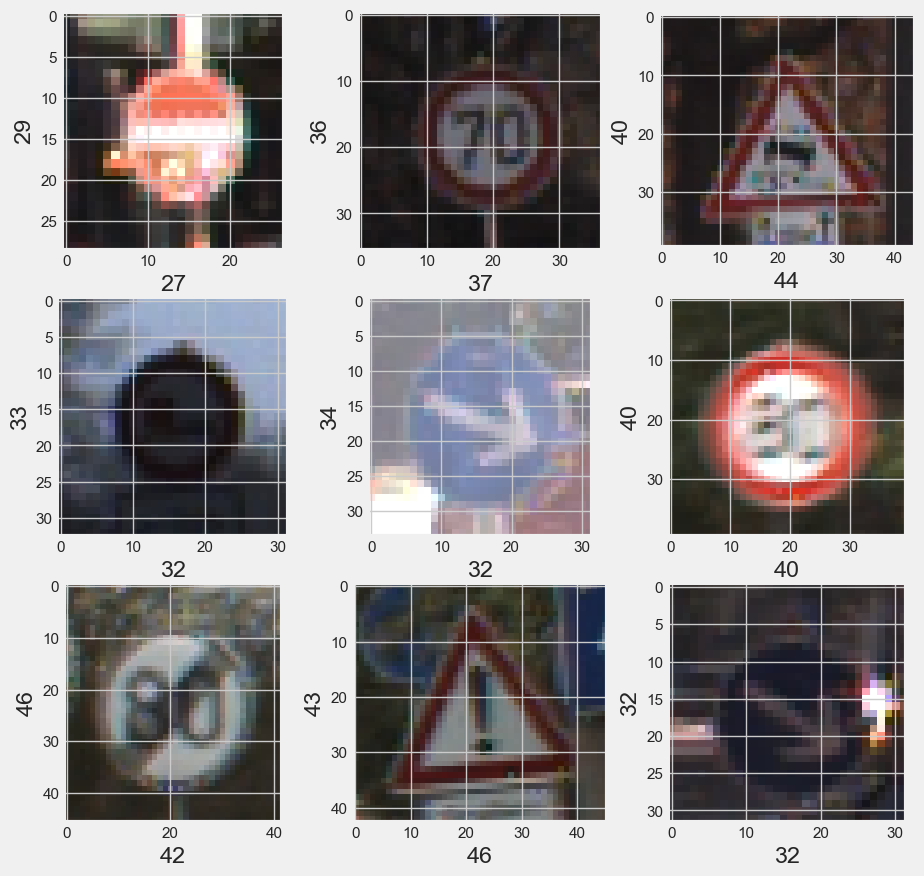

In [4]:
# Visualizing the images in the training dataset
test = pd.read_csv(os.path.join(test_path, "Test.csv"))  # Reading the test dataset
imgs = test["Path"].values  # Extracting the images from the test dataset

plt.figure(figsize=(10, 10))  # Setting the figure size

for i in range(1, 10):
    plt.subplot(3, 3, i)  # Creating subplots
    random_img_path = os.path.join(
        data_dir, random.choice(imgs)
    )  # Selecting a random image
    random_img = imread(random_img_path)  # Reading the image
    plt.imshow(random_img)  # Displaying the image
    plt.xlabel(random_img.shape[1])  # Setting the label for the x-axis
    plt.ylabel(random_img.shape[0])  # Setting the label for the y-axis

In [5]:
# Collecting the images and their labels
image_data = []  # Initializing the list for the images
image_labels = []  # Initializing the list for the labels

for i in range(NUM_CATEGORIES):
    path = os.path.join(data_dir, "Train", str(i))  # Setting the path of the folder
    images = os.listdir(path)  # Listing the images in the folder

    for img in images:
        try:
            image = cv2.imread(path + "/" + img)  # Reading the image
            image_from_array = Image.fromarray(
                image, "RGB"
            )  # Converting the image to RGB
            resized_image = image_from_array.resize(
                (IMG_HEIGHT, IMG_WIDTH)
            )  # Resizing the image
            image_data.append(
                np.array(resized_image)
            )  # Appending the image to the list
            image_labels.append(i)  # Appending the label to the list
        except:
            print("Error in reading the image" + img)

# Converting the lists to arrays
image_data = np.array(image_data)
image_labels = np.array(image_labels)


# Shuffling the dataset to avoid overfitting and under fitting of the model
shuffled_indices = np.arange(image_data.shape[0])  # Creating an array of indices
np.random.shuffle(shuffled_indices)  # Shuffling the indices

image_data = image_data[shuffled_indices]
image_labels = image_labels[shuffled_indices]

print(image_data.shape, image_labels.shape)  # Printing the shape of the arrays

(39209, 30, 30, 3) (39209,)


In [6]:
# Splitting the dataset into training and testing datasets
X_train, X_val, y_train, y_val = train_test_split(
    image_data, image_labels, test_size=0.2, random_state=42, shuffle=True
)  # Splitting the dataset into training and testing datasets

X_train = X_train / 255  # Normalizing the training dataset
X_val = X_val / 255  # Normalizing the testing dataset

print(
    "Training Dataset:", X_train.shape, y_train.shape
)  # Printing the shape of the training dataset
print(
    "Testing Dataset:", X_val.shape, y_val.shape
)  # Printing the shape of the testing dataset

y_train = keras.utils.to_categorical(
    y_train, NUM_CATEGORIES
)  # One-hot encoding the training dataset
y_val = keras.utils.to_categorical(
    y_val, NUM_CATEGORIES
)  # One-hot encoding the testing dataset

print(y_train.shape, y_val.shape)  # Printing the shape of the one-hot encoded datasets

Training Dataset: (31367, 30, 30, 3) (31367,)
Testing Dataset: (7842, 30, 30, 3) (7842,)
(31367, 43) (7842, 43)


In [7]:
# Declaring the hyperparameters
learning_rate = 0.001
epochs = 50

# Creating the model architecture using the Sequential API
model = keras.models.Sequential(
    [
        keras.layers.Conv2D(
            filters=32,
            kernel_size=(6, 6),
            input_shape=(IMG_HEIGHT, IMG_WIDTH, channels),
            activation="relu",
        ),  # Input layer of the model with 32 filters, kernel size of 6x6, input shape of 30x30x3 and relu activation function
        keras.layers.Conv2D(
            filters=32, kernel_size=(6, 6), activation="relu"
        ),  # Hidden layer of the model with 32 filters, kernel size of 6x6 and relu activation function
        keras.layers.MaxPooling2D(
            pool_size=(2, 2)
        ),  # Pooling layer of the model with pool size of 2x2
        keras.layers.Dropout(
            rate=0.25
        ),  # Dropout layer of the model with dropout rate of 0.25
        keras.layers.Conv2D(
            filters=64, kernel_size=(3, 3), activation="relu"
        ),  # Hidden layer of the model with 64 filters, kernel size of 3x3 and relu activation function
        keras.layers.Conv2D(
            filters=64, kernel_size=(3, 3), activation="relu"
        ),  # Hidden layer of the model with 64 filters, kernel size of 3x3 and relu activation function
        keras.layers.MaxPooling2D(
            pool_size=(2, 2)
        ),  # Pooling layer of the model with pool size of 2x2
        keras.layers.Dropout(
            rate=0.25
        ),  # Dropout layer of the model with dropout rate of 0.25
        keras.layers.Flatten(),  # Flattening layer of the model
        keras.layers.Dense(
            IMG_HEIGHT * IMG_WIDTH * channels, activation="relu"
        ),  # Hidden layer of the model with 2700 neurons and relu activation function
        keras.layers.Dropout(
            0.5
        ),  # Dropout layer of the model with dropout rate of 0.5
        keras.layers.Dense(
            NUM_CATEGORIES, activation="softmax"
        ),  # Output layer of the model with 43 neurons and softmax activation function
    ]
)

# Compiling the model
model.compile(
    loss="categorical_crossentropy",
    optimizer=Adam(learning_rate=learning_rate, decay=learning_rate / epochs),
    metrics=["accuracy"],
)

# Printing the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 25, 25, 32)        3488      
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 20, 32)        36896     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 10, 10, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 10, 10, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 6, 6, 64)          36928     
                                                        

In [8]:
# Data Augmentation to avoid overfitting and under fitting of the model
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest",
)

# Creating a callback to save the best model
checkpoint = keras.callbacks.ModelCheckpoint(
    "model/trained_model.keras",
    monitor="val_accuracy",
    verbose=1,
    save_best_only=True,
)

print(X_train.shape, y_train.shape)  # Printing the shape of the training dataset

# Training the model
history = model.fit(
    aug.flow(X_train, y_train, batch_size=64),
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint],
)

(31367, 30, 30, 3) (31367, 43)
Epoch 1/50
488/491 [============================>.] - ETA: 0s - loss: 1.9543 - accuracy: 0.4254
Epoch 1: val_accuracy improved from -inf to 0.89735, saving model to build\trained_model.keras
491/491 [==============================] - 11s 16ms/step - loss: 1.9486 - accuracy: 0.4270 - val_loss: 0.3636 - val_accuracy: 0.8973
Epoch 2/50
487/491 [============================>.] - ETA: 0s - loss: 0.5495 - accuracy: 0.8255
Epoch 2: val_accuracy improved from 0.89735 to 0.96366, saving model to build\trained_model.keras
491/491 [==============================] - 7s 15ms/step - loss: 0.5484 - accuracy: 0.8259 - val_loss: 0.1240 - val_accuracy: 0.9637
Epoch 3/50
487/491 [============================>.] - ETA: 0s - loss: 0.2944 - accuracy: 0.9075
Epoch 3: val_accuracy improved from 0.96366 to 0.98776, saving model to build\trained_model.keras
491/491 [==============================] - 7s 15ms/step - loss: 0.2944 - accuracy: 0.9073 - val_loss: 0.0467 - val_accuracy: 

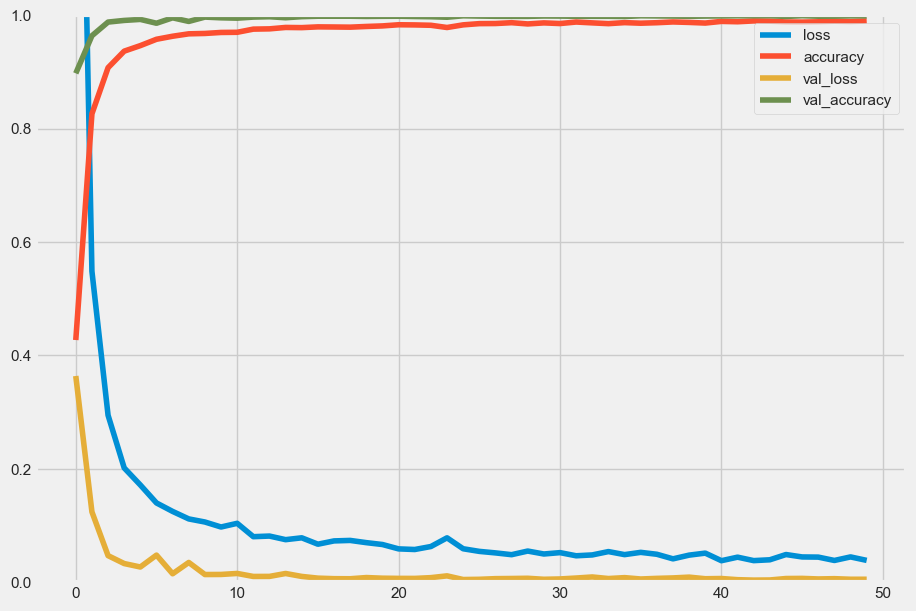

395/395 [==============================] - 1s 2ms/step
Accuracy Score: 98.63024544734759


In [9]:
# # Loading the best model from the saved model file
model = keras.models.load_model("model/trained_model.keras")

# Evaluating the model on the testing dataset
pd.DataFrame(history.history).plot(figsize=(10, 7))  # Plotting the loss and accuracy
plt.grid(True)  # Displaying the grid
plt.gca().set_ylim(0, 1)  # Setting the limit for the y-axis
plt.show()  # Displaying the plot

# Predicting the labels for the testing dataset
test = pd.read_csv(os.path.join(test_path, "Test.csv"))  # Reading the test dataset

labels = test["ClassId"].values  # Extracting the labels from the test dataset
imgs = test["Path"].values  # Extracting the images from the test dataset

data = []  # Initializing the list for the images

for img in imgs:
    try:
        image = cv2.imread(os.path.join(data_dir, img))  # Reading the image
        image_from_array = Image.fromarray(image, "RGB")  # Converting the image to RGB
        resized_image = image_from_array.resize(
            (IMG_HEIGHT, IMG_WIDTH)
        )  # Resizing the image
        data.append(np.array(resized_image))  # Appending the image to the list
    except:
        print("Error in reading the image" + img)

X_test = np.array(data)  # Converting the list to an array
X_test = X_test / 255  # Normalizing the testing dataset

pred = np.argmax(
    model.predict(X_test), axis=1
)  # Predicting the labels for the testing dataset


# Printing the accuracy score of the model
print("Accuracy Score:", accuracy_score(labels, pred) * 100)

              precision    recall  f1-score   support

           0       0.95      1.00      0.98        60
           1       0.98      1.00      0.99       720
           2       0.99      0.99      0.99       750
           3       1.00      0.98      0.99       450
           4       1.00      0.98      0.99       660
           5       0.98      0.99      0.98       630
           6       1.00      0.99      0.99       150
           7       1.00      1.00      1.00       450
           8       1.00      1.00      1.00       450
           9       0.99      0.98      0.99       480
          10       1.00      1.00      1.00       660
          11       1.00      0.94      0.97       420
          12       0.98      0.99      0.98       690
          13       1.00      1.00      1.00       720
          14       1.00      1.00      1.00       270
          15       0.98      1.00      0.99       210
          16       0.95      1.00      0.97       150
          17       1.00    

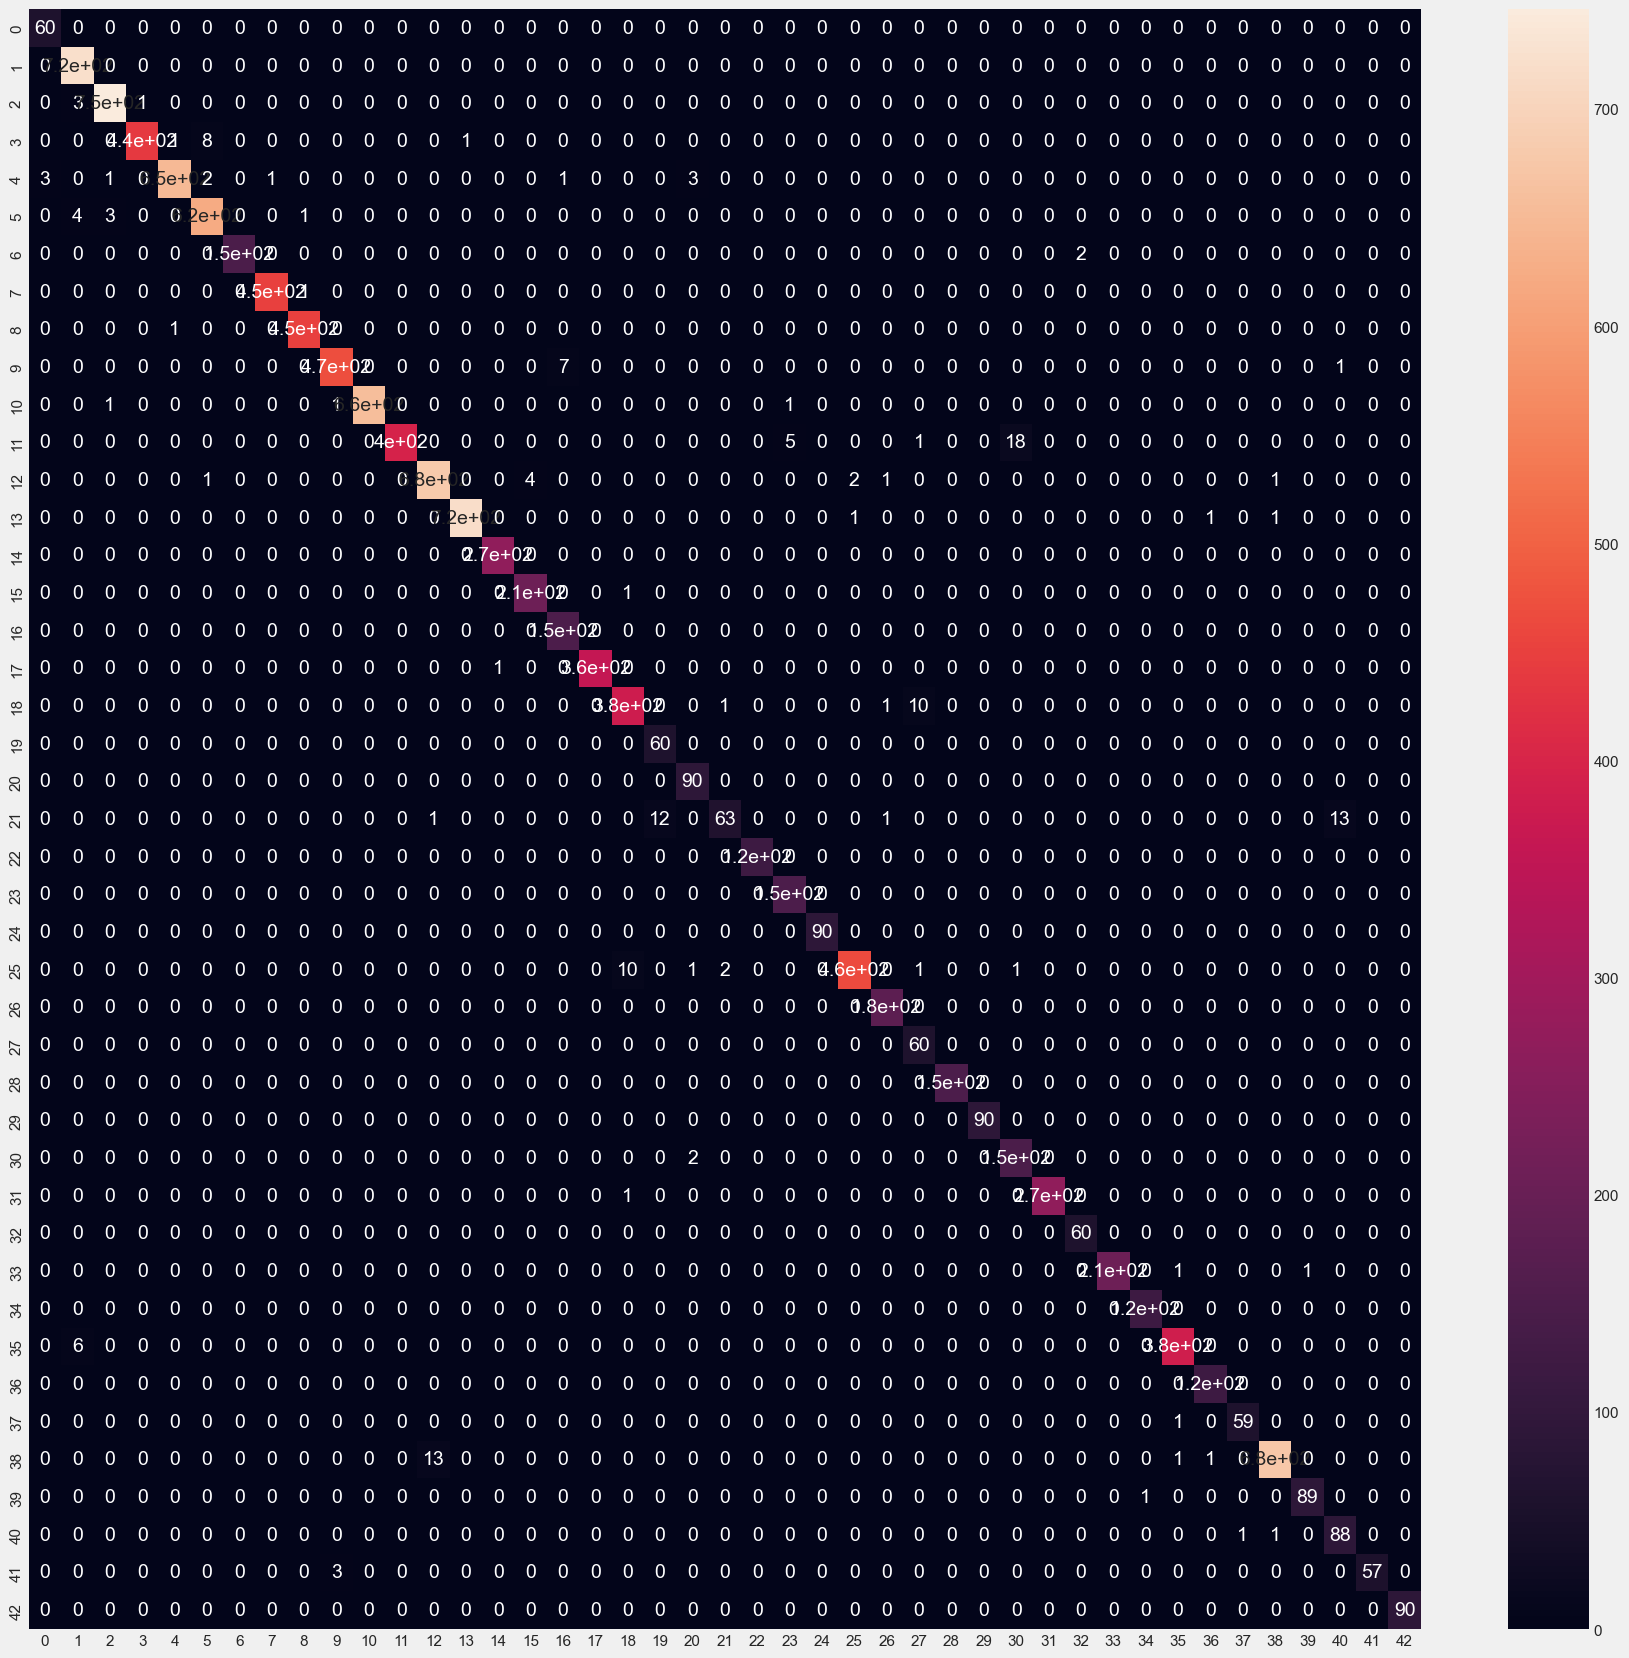

In [10]:
# Visualizing the confusion matrix of the model
cf = confusion_matrix(y_true=labels, y_pred=pred)  # Creating the confusion matrix
df_cm = pd.DataFrame(cf, index=classes, columns=classes)  # Creating the dataframe
plt.figure(figsize=(20, 20))  # Setting the figure size
sns.heatmap(df_cm, annot=True)  # Plotting the heatmap

# Printing the classification report of the model
print(classification_report(labels, pred))

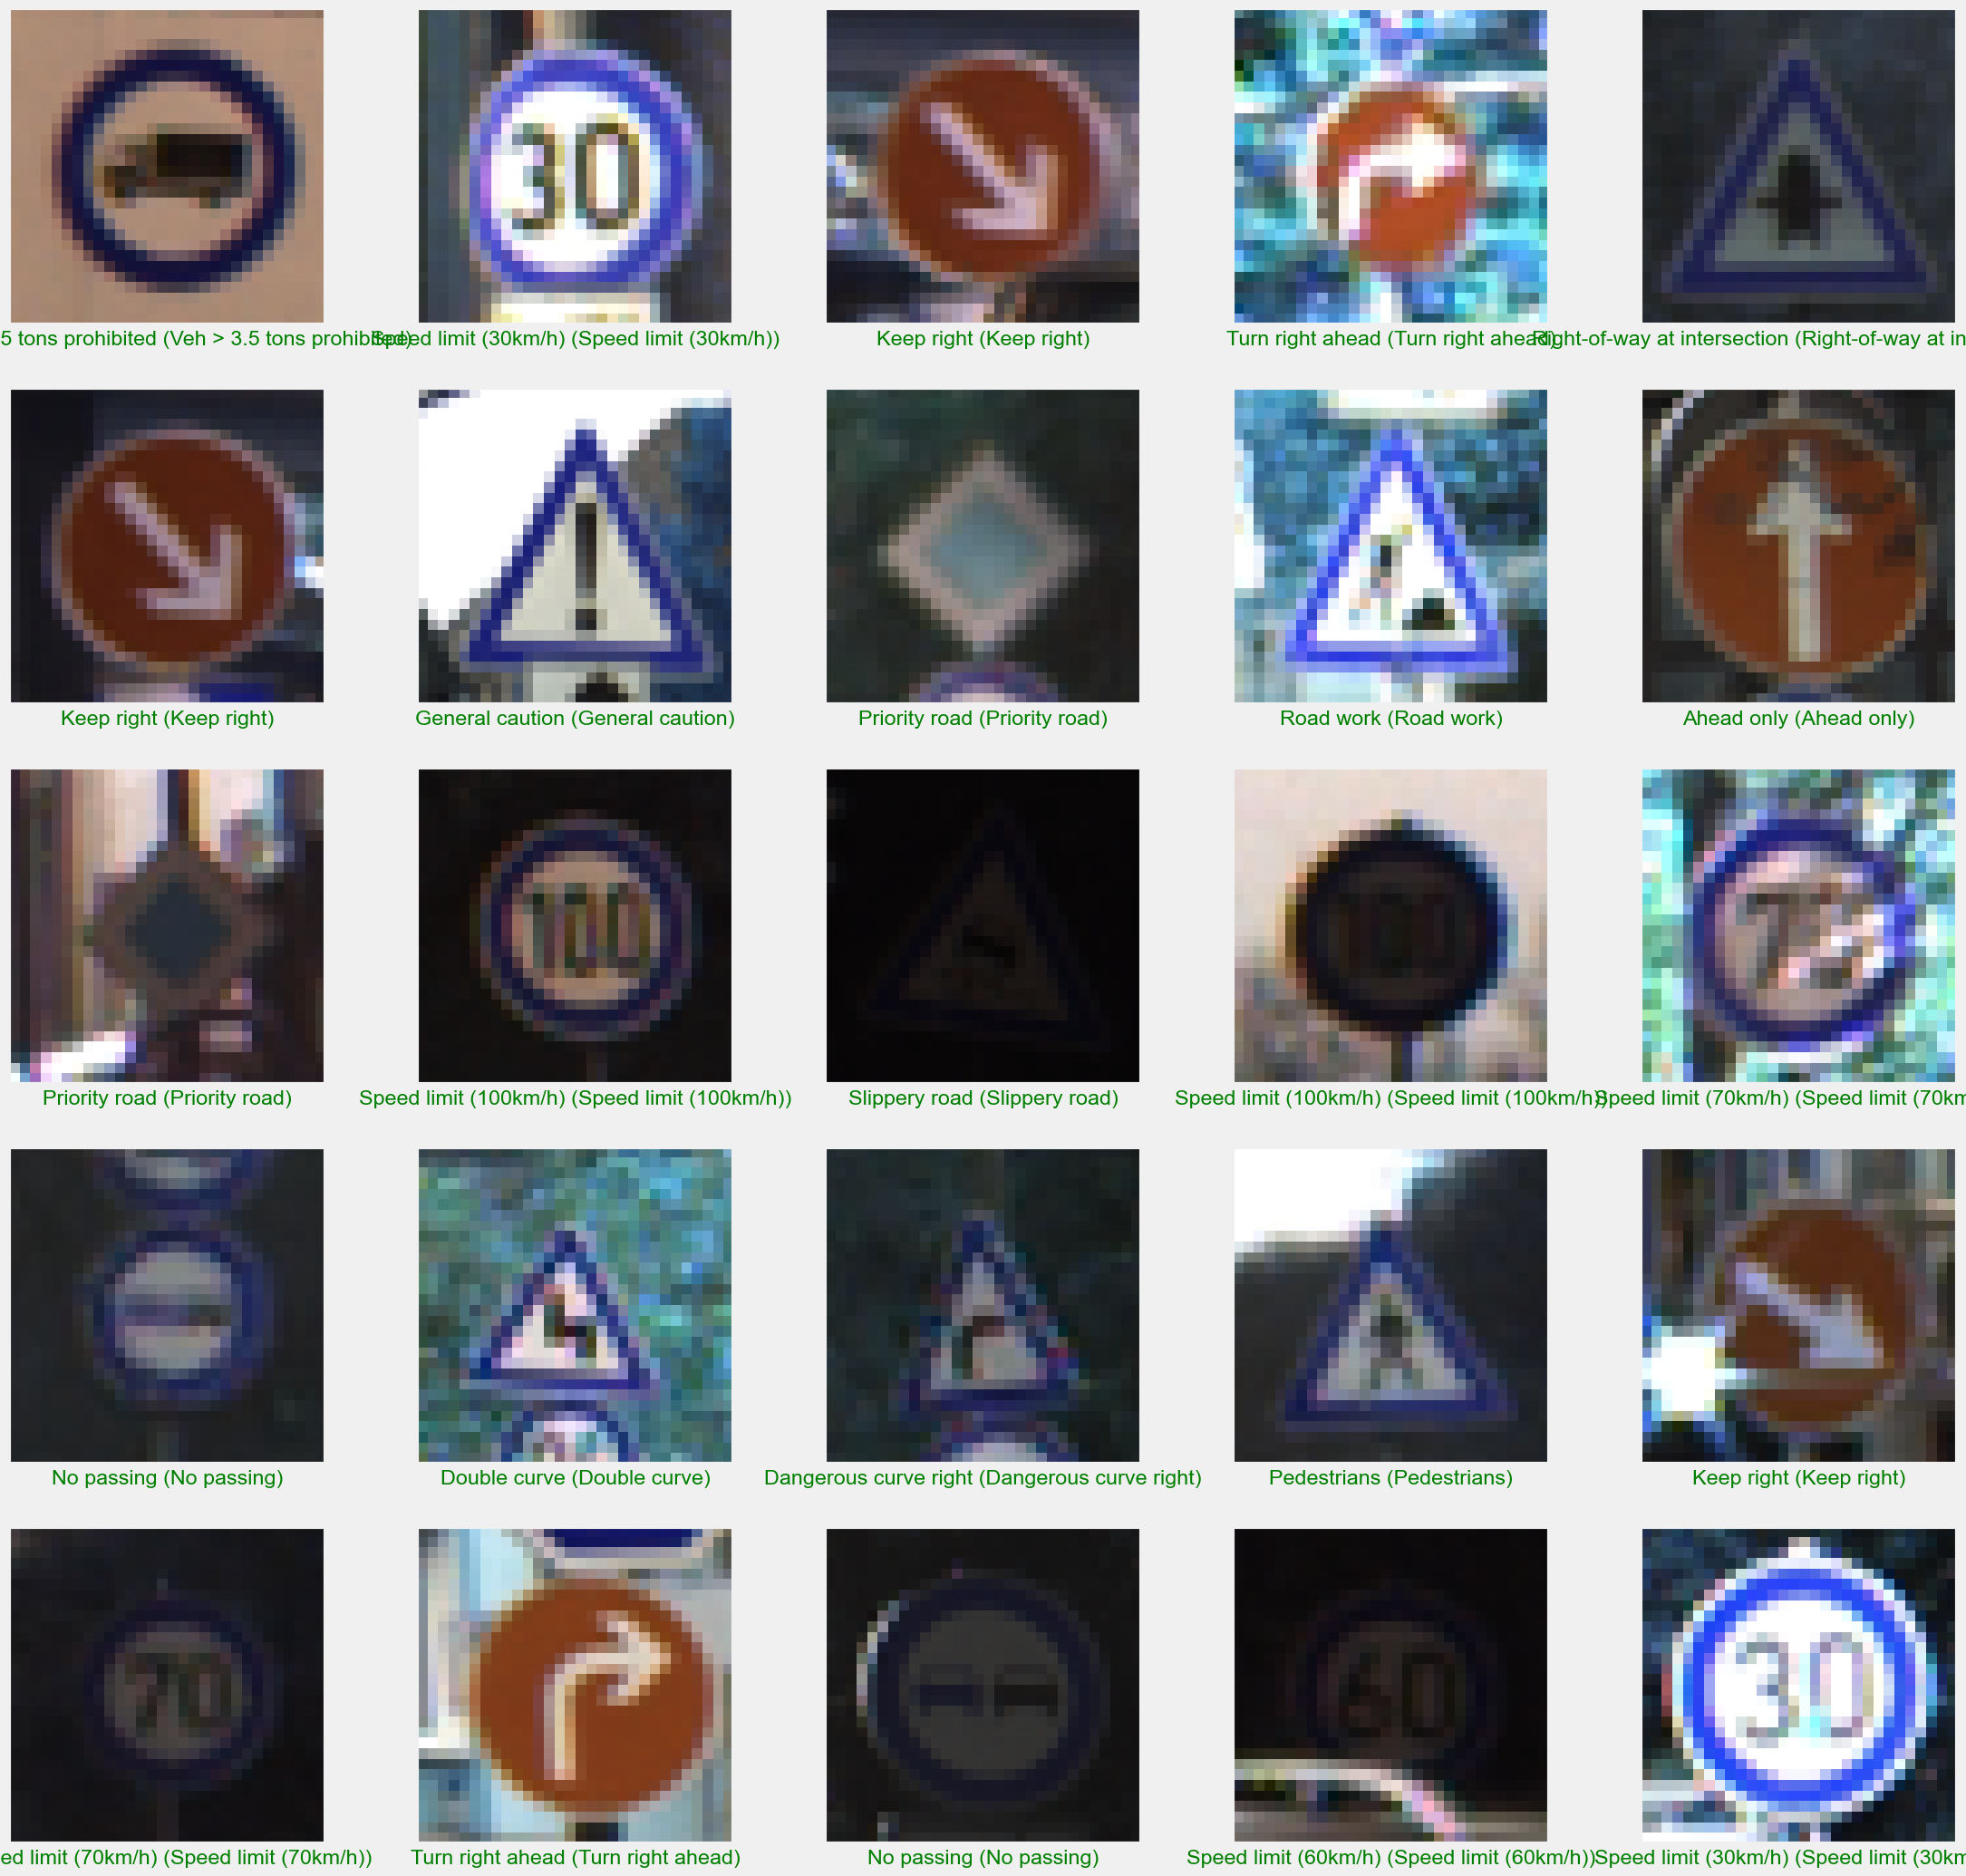

In [16]:
# Predicting the labels for the testing dataset
plt.figure(figsize=(25, 25))  # Setting the figure size

start_index = 0  # Initializing the start index
end_index = 25  # Initializing the end index

for i in range(start_index, end_index):
    plt.subplot(5, 5, i + 1 - start_index)  # Creating subplots
    plt.xticks([])  # Setting the ticks for the x-axis
    plt.yticks([])  # Setting the ticks for the y-axis
    plt.grid(False)  # Displaying the grid
    img = X_test[i]  # Selecting the image
    plt.imshow(img, cmap=plt.cm.binary)  # Displaying the image
    predicted_label = pred[i]  # Selecting the predicted label
    true_label = labels[i]  # Selecting the true label

    # Setting the color of the predicted label
    if predicted_label == true_label:
        color = "green"
    else:
        color = "red"

    # Setting the label for the image
    plt.xlabel(
        "{} ({})".format(classes[predicted_label], classes[true_label]), color=color
    )

In [12]:
# Save the model as a JSON file for production deployment
model_json = model.to_json()  # Converting the model to a JSON file
with open("model/trained_model.json", "w") as json_file:
    json_file.write(model_json)  # Writing the JSON file

In [15]:
count = 0
threshold = 0.5

# Predicting the labels for the Meta dataset
for i in range(0, 43):
    image = cv2.imread("./database/Meta/" + str(i) + ".png")  # Read the image

    img = np.asarray(image)  # Convert the image to an array
    img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))  # Resize the image

    img = img.reshape(1, IMG_HEIGHT, IMG_WIDTH, channels)  # Reshape the image
    predictions = model.predict(img)  # Predict the probability
    classIndex = np.argmax(predictions, axis=1)  # Predict the class
    probVal = np.amax(predictions)  # Get the maximum probability
    if probVal > threshold and classIndex[0] != i:
        count += 1
        print("Actual: ", classes[i], " Predicted: ", classes[classIndex[0]], " Prob: ", probVal)

print("Accuracy: ", count / 43)

1/1 [==============================] - 0s 14ms/step
Actual:  Speed limit (50km/h)  Predicted:  Roundabout mandatory  Prob:  1.0
1/1 [==============================] - 0s 23ms/step
Actual:  Speed limit (60km/h)  Predicted:  End no passing veh > 3.5 tons  Prob:  1.0
1/1 [==============================] - 0s 19ms/step
Actual:  Speed limit (70km/h)  Predicted:  Speed limit (20km/h)  Prob:  1.0
1/1 [==============================] - 0s 19ms/step
Actual:  Speed limit (80km/h)  Predicted:  Veh > 3.5 tons prohibited  Prob:  1.0
1/1 [==============================] - 0s 20ms/step
Actual:  End of speed limit (80km/h)  Predicted:  Priority road  Prob:  1.0
1/1 [==============================] - 0s 16ms/step
Actual:  Speed limit (100km/h)  Predicted:  Right-of-way at intersection  Prob:  1.0
1/1 [==============================] - 0s 18ms/step
Actual:  Speed limit (120km/h)  Predicted:  Speed limit (20km/h)  Prob:  1.0
1/1 [==============================] - 0s 14ms/step
Actual:  No passing  Predict